In [1]:
import pathlib
import re

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from PIL import Image

%matplotlib inline

## 1. Load PPG data

In [2]:
ppg_path = pathlib.Path('../data/PPG/')

### 1.1 Load case control status to `case_to_status` dictionary

In [3]:
case_control = pd.read_excel(ppg_path.joinpath('case_control_status.xlsx'))
case_to_status = (
    case_control
    .filter(items=['id', 'CaseControlStatus'])
    .set_index('id')
    .loc[:, 'CaseControlStatus']
    .to_dict()
)

### 1.2 Load features and labels

In [4]:
patient_dirs = list(ppg_path.glob('feature maps/*'))

n_patients = len(patient_dirs)

features = np.zeros((n_patients, 36, 30, 29))
labels = list()

for patient_number, patient_dir in enumerate(patient_dirs):
    # Load mask to NumPy array
    mask_path = next(patient_dir.glob('mask/*_mean.nii.gz'))
    mask = nib.load(mask_path.as_posix()).get_data().T
    
    # Load all features
    feature_maps = sorted(patient_dir.glob('feature/*.nii.gz'))
    assert len(feature_maps) == 29
    
    for feature_number, feature_path in enumerate(feature_maps):
        # Load feature and apply mask
        feature = nib.load(feature_path.as_posix()).get_data().T
        masked_feature = np.multiply(mask, np.nan_to_num(feature))
        
        features[patient_number, :, :, feature_number] = masked_feature
    
    # Add label to labels
    labels.append(case_to_status[patient_dir.name])
    
labels_array = np.array(labels)

np.savez_compressed('PPG_data.npz', x=features, y=labels_array)

## 2. Load prior data

In [5]:
prior_path = pathlib.Path('../data/secure/')

### 2.1 Load case control status to `case_to_status` dictionary

In [6]:
case_control = pd.read_excel(prior_path.joinpath(
    'largecohort_HUP_subsetOfPriors_July2017.xlsx'
))
case_to_status = (
    case_control
    .filter(items=['DummyID', 'Class'])
    .set_index('DummyID')
    .loc[:, 'Class']
    .to_dict()
)

### 2.2 Load features and labels

In [7]:
sample_paths = list(map(lambda path: path.parent, prior_path.glob('*/*/*/feature')))

#### 2.2.1 Downsample larger images using linear interpolation

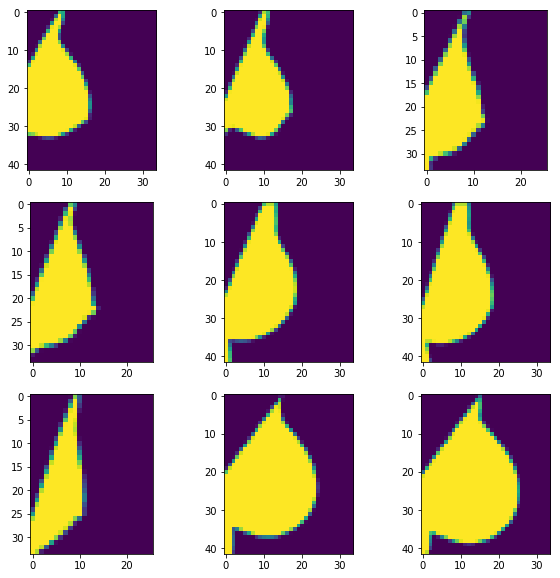

In [8]:
# Uneditied images

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    mask = nib.load(next(sample_paths[i].joinpath('mask/').glob('*_mean.nii.gz')).as_posix()).get_data().T
    plt.imshow(mask)

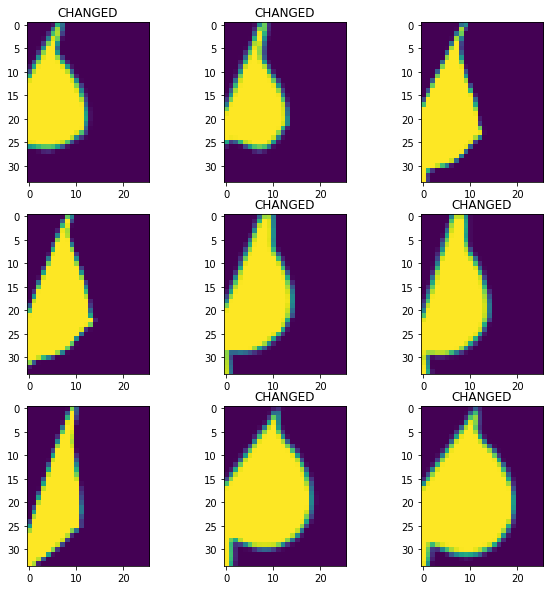

In [9]:
# Downsample images using linear interpolation

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    mask = nib.load(next(sample_paths[i].joinpath('mask/').glob('*_mean.nii.gz')).as_posix()).get_data().T
    if mask.shape == (42, 34):
        mask = np.array(Image.fromarray(mask).resize((26, 34), Image.LINEAR))
        ax.set_title("CHANGED")
    ax.imshow(mask)

#### 2.2.2 Combine features and save to file

In [10]:
n_samples = len(sample_paths)

features = np.zeros((n_samples, 34, 26, 29))
labels = list()

for sample_num, sample_dir in enumerate(sample_paths):
    mask_path = next(sample_dir.glob('mask/*_mean.nii.gz'))
    mask = nib.load(mask_path.as_posix()).get_data().T
    
    feature_maps = sorted(sample_dir.glob('feature/*.nii.gz'))
    assert len(feature_maps) == 29
    
    for feature_number, feature_path in enumerate(feature_maps):
        # Load feature and apply mask
        feature = nib.load(feature_path.as_posix()).get_data().T
        masked_feature = np.multiply(mask, np.nan_to_num(feature))
        
        if mask.shape == (42, 34):
            masked_feature = np.array(
                Image
                .fromarray(masked_feature)
                .resize((26, 34), Image.LINEAR)
            )

        features[sample_num, :, :, feature_number] = masked_feature   
    
    # Add label to labels
    labels.append(case_to_status[int(sample_dir.parent.parent.name)])

labels_array = np.array(labels)

np.savez_compressed('prior_data.npz', x=features, y=labels_array)